### Step 1
Initialize Spark Session

In [1]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-streaming-kafka-0-10_2.12:3.0.0,org.apache.spark:spark-sql-kafka-0-10_2.12:3.0.0 pyspark-shell'

from pyspark.sql import SparkSession
from pyspark.sql.functions import explode
from pyspark.sql.functions import split
from pyspark.sql import functions as F
from pyspark.sql.types import *

spark = SparkSession \
    .builder \
    .appName("Week 11 - Granularity Reduction") \
    .getOrCreate()

### Step 2
Connection to Kafka Producer/Broker and subscribe to the topic and load data from Kafka topic with <code>readStream</code>

In [2]:
#configuration
hostip = "192.168.100.4" #change me
topic = "week11_orig_data"
df = spark \
    .readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", f"{hostip}:9092") \
    .option("subscribe", topic) \
    .load()

In [3]:
df.printSchema()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



### Step 3 
Converting the value from the kafka data stream to string

In [4]:
df = df.selectExpr("CAST(value AS STRING)")

In [5]:
df.printSchema()

root
 |-- value: string (nullable = true)



### Step 4
Define a schema according to our data (as sent from the producer), Use <code>from_json</code> to parse the string to the json format based on the defined schema.
Each message contains the value of the timestamp as "ts" field and a random integer value as "value" field, you can define a schema as follows

In [6]:
schema = StructType([
    StructField('ts', TimestampType(), True),
    StructField('value', IntegerType(), True)          
])

In [7]:
df=df.select(F.from_json(F.col("value").cast("string"), schema).alias('parsed_value'))

In [8]:
df.printSchema()

root
 |-- parsed_value: struct (nullable = true)
 |    |-- ts: timestamp (nullable = true)
 |    |-- value: integer (nullable = true)



The columns need to be renamed appropriately.

In [9]:
df_formatted = df.select(
                    F.col("parsed_value.ts").alias("ts"),
                    F.col("parsed_value.value").alias("value")
                )

In [10]:
df_formatted.printSchema()

root
 |-- ts: timestamp (nullable = true)
 |-- value: integer (nullable = true)



### Step 5
Reduce the value of the data by grouping the timestamp "ts" on a window of 5 seconds  

In [11]:
#Using the window function, we can perform the following aggregation 
grouped_avg = df_formatted.groupBy(F.window("ts","5 second"))\
                    .agg(F.avg("value").alias("avg_value"))

In [12]:
grouped_avg.printSchema()

root
 |-- window: struct (nullable = false)
 |    |-- start: timestamp (nullable = true)
 |    |-- end: timestamp (nullable = true)
 |-- avg_value: double (nullable = true)



Parsing and renaming the columns appropriately

In [13]:
grouped_avg = grouped_avg.select(
                    F.col("window.end").alias("end_time"),
                    F.col("avg_value")
                )

In [14]:
grouped_avg.printSchema()

root
 |-- end_time: timestamp (nullable = true)
 |-- avg_value: double (nullable = true)



### Step 6
Create the <strong>output sink</strong> for the stream. For this case, we will output the data in memory. One will output the original random values in a table called  "query_all" and the reduced values in another table called "reduced_values".

In [15]:
#Change the output sink to "memory" and write output to the memory sink
query_all = df_formatted \
    .writeStream \
    .outputMode("append") \
    .format("memory") \
    .queryName("all_values") \
    .trigger(processingTime='5 seconds') \
    .start()

In [16]:
#Change the output sink to "memory" and write output to the memory sink
query_reduced = grouped_avg \
    .writeStream \
    .outputMode("complete") \
    .format("memory") \
    .queryName("reduced_values") \
    .trigger(processingTime='5 seconds') \
    .start()

In [21]:
spark.sql("select * from all_values order by ts asc").show()
spark.sql("select * from reduced_values order by end_time asc").show()

+-------------------+-----+
|                 ts|value|
+-------------------+-----+
|2022-05-27 20:18:20|   73|
|2022-05-27 20:18:21|   52|
|2022-05-27 20:18:22|   56|
|2022-05-27 20:18:23|   82|
|2022-05-27 20:18:24|   74|
|2022-05-27 20:18:25|   49|
|2022-05-27 20:18:26|   82|
+-------------------+-----+

+-------------------+---------+
|           end_time|avg_value|
+-------------------+---------+
|2022-05-27 20:18:25|     66.0|
|2022-05-27 20:18:30|     55.8|
|2022-05-27 20:18:35|     48.0|
|2022-05-27 20:18:40|     22.4|
|2022-05-27 20:18:45|     82.0|
+-------------------+---------+



### Visualizing streaming data 
We have implemented the aggregation to get the average values of the random data in a window of 5 seconds. Let's write this this to the memory sink and query it using spark sql for visualizing it in real time.

Here, first we need to initialize an empty plot.

In [22]:
def init_plots():
    try:
        width = 9.5
        height = 6
        fig = plt.figure(figsize=(width,height)) # create new figure
        fig.subplots_adjust(hspace=0.8)
        ax = fig.add_subplot(111) # adding the subplot axes to the given grid position
        ax.set_xlabel('Time')
        ax.set_ylabel('Value')
        ax.title.set_text('Time Vs Value')
        fig.suptitle('Real-time uniform stream data visualization') # giving figure a title
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax
    except Exception as ex:
        print(str(ex))

<IPython.core.display.Javascript object>


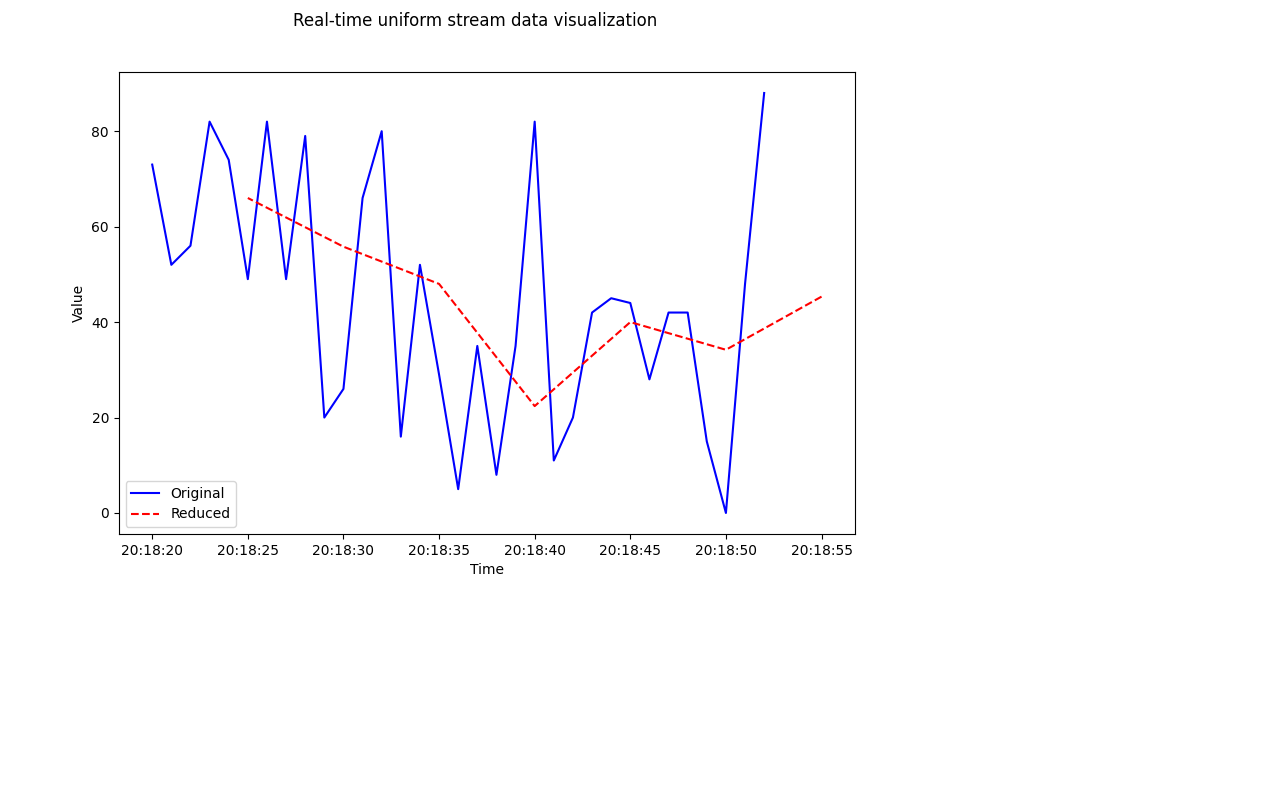

In [ ]:
import time
import matplotlib.pyplot as plt
%matplotlib notebook

fig, ax = init_plots()

while True:
    df_all = spark.sql("select * from all_values order by ts desc limit 90").toPandas()
    # Get starting timestamp to plot both graphs
    start_time = df_all['ts'][len(df_all)-1]
    df_reduced = spark.sql("select * from reduced_values where end_time>='"+str(start_time)+"' order by end_time desc").toPandas()
    
    x_all = df_all['ts'].to_list()
    y_all = df_all['value'].to_list()
    x_reduced = df_reduced['end_time'].to_list()
    y_reduced = df_reduced['avg_value'].to_list()
    ax.clear()
    ax.plot(x_all, y_all, '-b', label='Original')
    ax.plot(x_reduced, y_reduced, '--r', label='Reduced')
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    leg = ax.legend()
    fig.canvas.draw()
    
    time.sleep(5)
    